In [1]:
import numpy as np                                                                        
import matplotlib.pyplot as plt
import pyCloudy as pc
import pyneb as pn
from astropy    import constants as const
from astropy.io import ascii
import pandas as pd
from scipy import interpolate
import warnings
from scipy.integrate import quad, IntegrationWarning
# from scipy.integrate import simps
from numpy import log10, exp

kpc = const.kpc.cgs.value

atom = ['Lya','HeII','CIV']

def read_file(path_way, atom):
    Mod = pc.CloudyModel(path_way, cloudy_version_major=23)
    Mod.ionic_names

    N_H = sum(Mod.dr*Mod.nH)
    # solar_metallicitiy from von Steiger et al. 2016
    frac_He = 1.0E-01
    frac_C = 4.47E-04
    frac_O = 6.61E-04
    frac_N = 9.33E-05
    frac_Mg = 7.08E-05

    N_HI = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',0))
    N_HII = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',1))
    N_HeII = frac_He*sum(Mod.dr*Mod.nH*Mod.get_ionic('He',1))
    N_OVI = frac_O*sum(Mod.dr*Mod.nH*Mod.get_ionic('O',5))
    N_NV = frac_N*sum(Mod.dr*Mod.nH*Mod.get_ionic('N',4))
    N_CIV = frac_C*sum(Mod.dr*Mod.nH*Mod.get_ionic('C',3))

    num = len(Mod.nH)
    r_CIV = path_way +  '.ele_C'
    f = open(r_CIV,'r')
    header = f.readline()
    CIV_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[4])
        CIV_frac[i] = j
        i = i + 1

    r_He = path_way +  '.ele_He'
    f = open(r_He,'r')
    header = f.readline()
    HeII_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[2])
        HeII_frac[i] = j
        i = i + 1



    n_H= Mod.nH
    n_He = n_H*frac_He
    n_C = n_H*frac_C
    nden_CIV = CIV_frac*n_C
    nden_HeII = HeII_frac*n_He

    # tt = nden_CIV / n_H
    # print(tt.mean())

    if atom == 'CIV':
        Cloudy_Lum = float(Mod.get_emis_vol('C__4_154819A')) + float(Mod.get_emis_vol('C__4_155078A'))
        Cloudy_emis = (Mod.get_emis('C__4_154819A')) + (Mod.get_emis('C__4_155078A'))
        Cloudy_den = nden_CIV
    elif atom == 'Lya':
        Cloudy_Lum= float(Mod.get_emis_vol('H__1_121567A'))
        Cloudy_emis = Mod.get_emis('H__1_121567A')
        Cloudy_den = n_H
    elif atom == 'HeII':
        Cloudy_Lum = float(Mod.get_emis_vol('HE_2_164043A'))
        Cloudy_emis = Mod.get_emis('HE_2_164043A')
        Cloudy_den = nden_HeII
    return Cloudy_Lum , Cloudy_emis ,Cloudy_den

def radius(path, atom):
    Mod = pc.CloudyModel(path, cloudy_version_major=23)
    radius = Mod.radius/kpc
    radius_kpc =Mod.radius 
    dr = Mod.dr 
    return radius, radius_kpc, dr

def make_data_file(path,atom):
    lum ,emis ,den = read_file(path,atom)
    radius_R , radius_kpc , dr=  radius(path,atom)
    tt =  pd.DataFrame(np.column_stack((radius_R,emis,den)))
    tt.to_csv('/home/jin/T_Cloudy/CIV_cloudy.txt', sep='\t',index=False,header =False)
    tt.to_csv('/home/jin/RT_code/CIV_cloudy.txt', sep='\t',index = False,header=False)
    return print("make data file!")

def SB(z,radius_kpc, emissivity,dr ):
    r_min, r_max = radius_kpc.min(), radius_kpc.max()  
    # N = len(rt_radius)     
    # Project_R = np.copy(rt_radius)
    Project_R  = np.linspace(0,100,100) * kpc
    N = len(Project_R )
    surface_brightness = np.zeros(N)
    Lumin = np.zeros(N)
    T_Lumin = np.zeros(N)
    dR_pro = Project_R[1] -Project_R[0] 
    for ii, bb in enumerate(Project_R):
        array_R = np.where(radius_kpc >= bb)[0]
        r_surface_brightness = 0
        for dR in (array_R):
            r_surface_brightness += emissivity[dR] * dr[dR] 

        if bb ==0 :
            bb = dR_pro
            surface_brightness[ii] = 4*r_surface_brightness / (1+z)**4 
            Lumin[ii] = np.pi*bb*surface_brightness[ii] * dR_pro * (1+z)**4
        else :
            surface_brightness[ii] = 4*r_surface_brightness / (1+z)**4 
            Lumin[ii] = 2*np.pi*bb*surface_brightness[ii] * dR_pro * (1+z)**4

    return Project_R/ kpc, surface_brightness, Lumin


    



def RT_SB(path):
    name = ['radius','SB_K','SB_H','SB_tot','1','2','3']
    data_sp = pd.read_csv(path, sep='\s+', header=None,names=name)
    rad, SB_t, SB_k,SB_h =  data_sp['radius'].to_numpy(),data_sp['SB_tot'].to_numpy(),data_sp['SB_K'].to_numpy(),data_sp['SB_H'].to_numpy()
    return rad*100, rad*100*kpc, SB_t 

def find_y(x_find,x,y):
    ii = int(np.where(x <= x_find)[0][-1])
    # print(ii)
    y_find = (y[ii+1] -y[ii]) / (x[ii+1] - x[ii])*(x_find - x[ii]) + y[ii]
    return y_find

warnings.filterwarnings("ignore", category=IntegrationWarning)

warng pyCloudy config: pyCloudy works better with matplotlib Triangulation


In [2]:
# RT_path_LT =r'/home/jin/T_Cloudy/OTS_n_LT_y/data_RT/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'
RT_path_LT= r'/home/jin/RT_code/data_test/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
path_LT = r'/home/jin/T_Cloudy/OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT

cloudy_model = ['LT'] # or - original (no LT, no Diffuse OTS) , n - no LT (on OTS), y - on LT , OTS, LT- no OTS (on LT)
atom_N = 'CIV'
def make_parameter(path,RT_path,atom,cloudy_index):
    z_red_Shift = 0
    globals()['radius_{}'.format(cloudy_index)] , globals()['radius_kpc_{}'.format(cloudy_index)], globals()['dr_{}'.format(cloudy_index)] = radius(path,atom)
    globals()['civ_lum_{}'.format(cloudy_index)] , globals()['civ_emis_{}'.format(cloudy_index)] , globals()['civ_den_{}'.format(cloudy_index)] = read_file(path,atom)
    globals()['rt_radius_{}'.format(cloudy_index)] , globals()['rt_radius_kpc_{}'.format(cloudy_index)], globals()['rt_sb_t_{}'.format(cloudy_index)] = RT_SB(RT_path)
    globals()['p_radius_{}'.format(cloudy_index)] , globals()['sb_{}'.format(cloudy_index)], globals()['lum_sb_{}'.format(cloudy_index)] = SB(z_red_Shift,globals()['radius_kpc_{}'.format(cloudy_index)],globals()['civ_emis_{}'.format(cloudy_index)]  , globals()['dr_{}'.format(cloudy_index)] ) # , globals()['rt_radius_kpc_{}'.format(cloudy_index)]
    return print("make parameters of {}".format(cloudy_index))

for ii ,cloudy_index in enumerate (cloudy_model) :
    make_parameter(globals()["path_{}".format(cloudy_index)],globals()["RT_path_{}".format(cloudy_index)],atom_N, cloudy_model[ii])

# rt_sb_t_LT = rt_sb_t_LT / np.sum(rt_sb_t_LT)

make parameters of LT


1.5562392548078622e+40 1.5578665190756982e+40


(-0.5, 100.0)

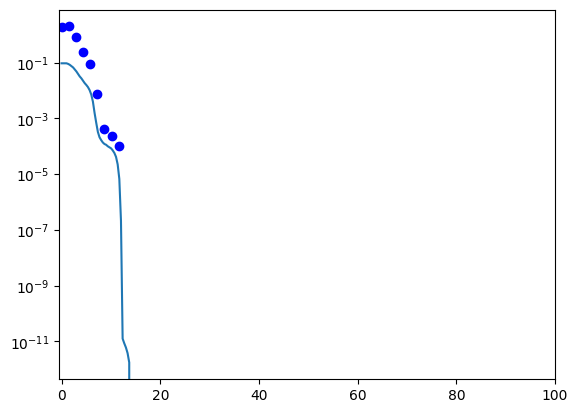

In [3]:
def SB(z,radius_kpc, emissivity,dr):
    r_min, r_max = radius_kpc.min(), radius_kpc.max()  
    Project_R  = np.linspace(0,100,300) * kpc
    N = len(Project_R )
    surface_brightness = np.zeros(N)
    Lumin = np.zeros(N)
    T_Lumin = np.zeros(N)
    dR_pro = Project_R[1] -Project_R[0] 
    for ii, bb in enumerate(Project_R):
        array_R = np.where(radius_kpc >= bb)[0]
        r_surface_brightness = 0
        for dR in (array_R):
            r_surface_brightness += emissivity[dR] * dr[dR] 
        surface_brightness[ii] = 2*r_surface_brightness / (1+z)**4 
        Lumin[ii] = 4*np.pi*bb*surface_brightness[ii] * dR_pro * (1+z)**4

    return Project_R/ kpc, surface_brightness ,Lumin

aa ,bb, cc  = SB(0,radius_kpc_LT,civ_emis_LT,dr_LT)
print(sum(cc), civ_lum_LT)
normal = np.sum(bb)
plt.plot(aa,bb/normal)

normal = np.sum(rt_sb_t_LT)
plt.plot(rt_radius_LT,rt_sb_t_LT /normal * 5,'bo')

plt.yscale('log')
plt.xlim(-0.5,100)

In [4]:
def SB(z,radius_kpc, emissivity,dr , rt_radius):

    emis_int = interpolate.interp1d(radius_kpc, emissivity)

    r_min, r_max = radius_kpc.min(), radius_kpc.max()

    Project_R = np.linspace(0, r_max, 70)

    surface_brightness = np.zeros(len(Project_R))

    for ii, R in enumerate(Project_R):

        def function(r):
            if r <= r_min:

                emis = 0
            else:

                emis = emis_int(r)
                yy = emis
                return yy 



        if R < r_min:

            surface_brightness[ii], _ = quad(function, r_min, r_max)    

        else:

            surface_brightness[ii], _ = quad(function, R, r_max)   



    tt = interpolate.interp1d(Project_R, 2*surface_brightness)


    dR = Project_R[1] - Project_R[0]
    def test(r):

        SB_new = tt(r)
        if r == 0:
            yy = SB_new * dR
        else :
            yy = SB_new * r
        return yy

    LL, _ = quad(test,0,r_max)



    return Project_R / kpc, 2*surface_brightness , LL * 4 *np.pi

In [108]:
# def SB(z,radius_kpc, emissivity,dr , rt_radius):

#     emis_int = interpolate.interp1d(radius_kpc, emissivity)

#     r_min, r_max = radius_kpc.min(), radius_kpc.max()

#     Project_R = np.linspace(0, r_max, 100)

#     surface_brightness = np.zeros(len(Project_R))

#     for ii, R in enumerate(Project_R):

#         def function(r):

#             if r <= r_min:

#                 emis = emis_int(r)

#                 return emis

#             else:

#                 emis = emis_int(r)

#                 if r**2 - R**2 <= 0:  # 분모가 0이 되는 경우 처리

#                     return 0  # 또는 적절한 값을 반환

#                 yy = emis * r / np.sqrt(r**2 - R**2)

#                 return yy 



#         if R <= r_min:

#             surface_brightness[ii], _ = quad(function, r_min, r_max)    

#         else:

#             surface_brightness[ii], _ = quad(function, R, r_max)   



#     tt = interpolate.interp1d(Project_R, 2*surface_brightness)



#     def test(r):

#         SB_new = tt(r)

#         return SB_new * r

#     LL, _ = quad(test,0,r_max)



#     return Project_R / kpc, 2*surface_brightness , LL * 2 *np.pi

In [109]:
# RT_path_LT =r'/home/jin/T_Cloudy/OTS_n_LT_y/data_RT/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'
RT_path_LT= r'/home/jin/RT_code/data_test/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
path_LT = r'/home/jin/T_Cloudy/OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT

cloudy_model = ['LT'] # or - original (no LT, no Diffuse OTS) , n - no LT (on OTS), y - on LT , OTS, LT- no OTS (on LT)
atom_N = 'CIV'
def make_parameter(path,RT_path,atom,cloudy_index):
    z_red_Shift = 0
    globals()['radius_{}'.format(cloudy_index)] , globals()['radius_kpc_{}'.format(cloudy_index)], globals()['dr_{}'.format(cloudy_index)] = radius(path,atom)
    globals()['civ_lum_{}'.format(cloudy_index)] , globals()['civ_emis_{}'.format(cloudy_index)] , globals()['civ_den_{}'.format(cloudy_index)] = read_file(path,atom)
    globals()['rt_radius_{}'.format(cloudy_index)] , globals()['rt_radius_kpc_{}'.format(cloudy_index)], globals()['rt_sb_t_{}'.format(cloudy_index)] = RT_SB(RT_path)
    globals()['p_radius_{}'.format(cloudy_index)] , globals()['sb_{}'.format(cloudy_index)], globals()['lum_sb_{}'.format(cloudy_index)] = SB(z_red_Shift,globals()['radius_kpc_{}'.format(cloudy_index)],globals()['civ_emis_{}'.format(cloudy_index)]  , globals()['dr_{}'.format(cloudy_index)] , globals()['rt_radius_kpc_{}'.format(cloudy_index)])
    return print("make parameters of {}".format(cloudy_index))

for ii ,cloudy_index in enumerate (cloudy_model) :
    make_parameter(globals()["path_{}".format(cloudy_index)],globals()["RT_path_{}".format(cloudy_index)],atom_N, cloudy_model[ii])

# rt_sb_t_LT = rt_sb_t_LT / np.sum(rt_sb_t_LT)

make parameters of LT


In [110]:
print(civ_lum_LT , np.sum(lum_sb_LT)*2)

1.5578665190756982e+40 3.2116584968563905e+40


(0.0, 20.0)

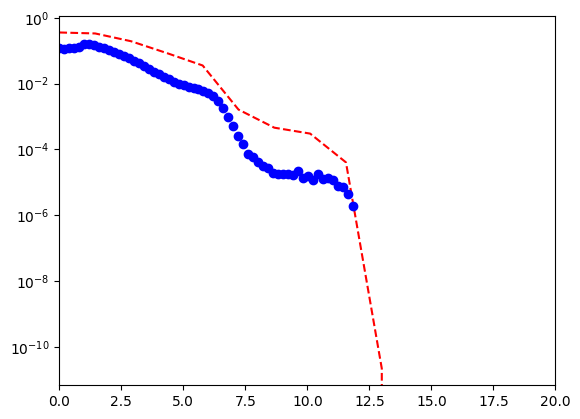

In [111]:
normal = np.sum(sb_LT)
plt.plot(p_radius_LT, sb_LT/normal,'r--')

normal = np.sum(rt_sb_t_LT)
plt.plot(rt_radius_LT,rt_sb_t_LT /normal * 2,'bo')
plt.yscale('log')
plt.xlim(0,20)